In [ ]:
# Check for GPU
!nvidia-smi

Wed Apr 30 17:08:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.6.0+cu124


'cuda'

1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Increase Model Complexity: Utilize more complex models with additional layers or neurons to better capture data pattern.
2. Feature Engineering: Add or create new relevant features that provide more information to the model, enhancing its ability to learn.
3. Train for More Epochs: Allow the model to learn longer by increasing the number of training epochs, giving it more opportunities to adjust weights effectively.

2. Recreate the data loading functions we built in sections 1, 2, 3 and 4 of notebook 04. You should have train and test DataLoader's ready to use.

In [1]:
import requests
import zipfile
from pathlib import Path

# Define data and image paths
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Check if the directory exists
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download the dataset
    download_url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
    zip_path = data_path / "pizza_steak_sushi.zip"

    print("Downloading pizza_steak_sushi.zip...")
    response = requests.get(download_url)
    with open(zip_path, "wb") as f:
        f.write(response.content)

    # Unzip the dataset
    print("Unzipping pizza_steak_sushi.zip...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(image_path)

    print("Done!")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza_steak_sushi.zip...
Done!


In [2]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [3]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

walk_through_dir(train_dir)
walk_through_dir(test_dir)

There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [5]:
# Visualize an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

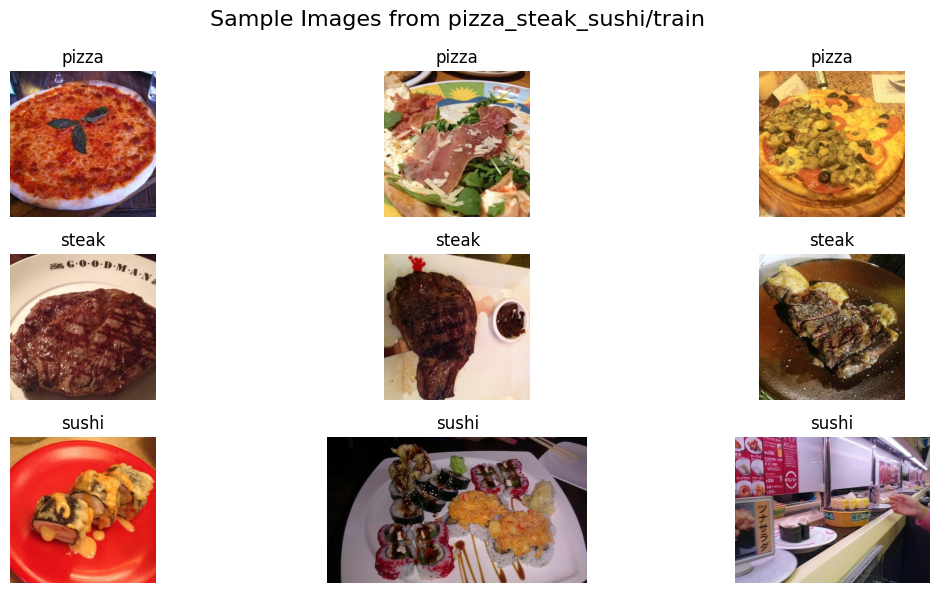

In [8]:
# Do the image visualization with matplotlib
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

# Path to the training directory
train_dir = Path("data/pizza_steak_sushi/train")

# Get the class names (e.g., pizza, steak, sushi)
class_names = sorted(os.listdir(train_dir))

# Number of images to display per class
num_images_per_class = 3

# Set up the plot
plt.figure(figsize=(12, 6))

# Loop through each class and display a few random images
for class_index, class_name in enumerate(class_names):
    class_path = train_dir / class_name
    image_paths = list(class_path.glob("*.jpg"))
    selected_images = random.sample(image_paths, num_images_per_class)

    for i, image_path in enumerate(selected_images):
        img = mpimg.imread(image_path)
        plt.subplot(len(class_names), num_images_per_class, class_index * num_images_per_class + i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(class_name)

plt.suptitle("Sample Images from pizza_steak_sushi/train", fontsize=16)
plt.tight_layout()
plt.show()

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:

Transform the data into tensors.
Turn the tensor data into a torch.utils.data.Dataset and later a torch.utils.data.DataLoader.

In [9]:
# 3.1 Transforming data with torchvision.transforms
from torchvision import transforms

In [11]:
# Write transform for turning images into tensors

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),              # Resize images to 224x224
    transforms.ToTensor(),                      # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # Normalize with ImageNet mean/std
                         std=[0.229, 0.224, 0.225])
])

In [13]:
from torchvision import datasets

# Apply transform to the training data
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

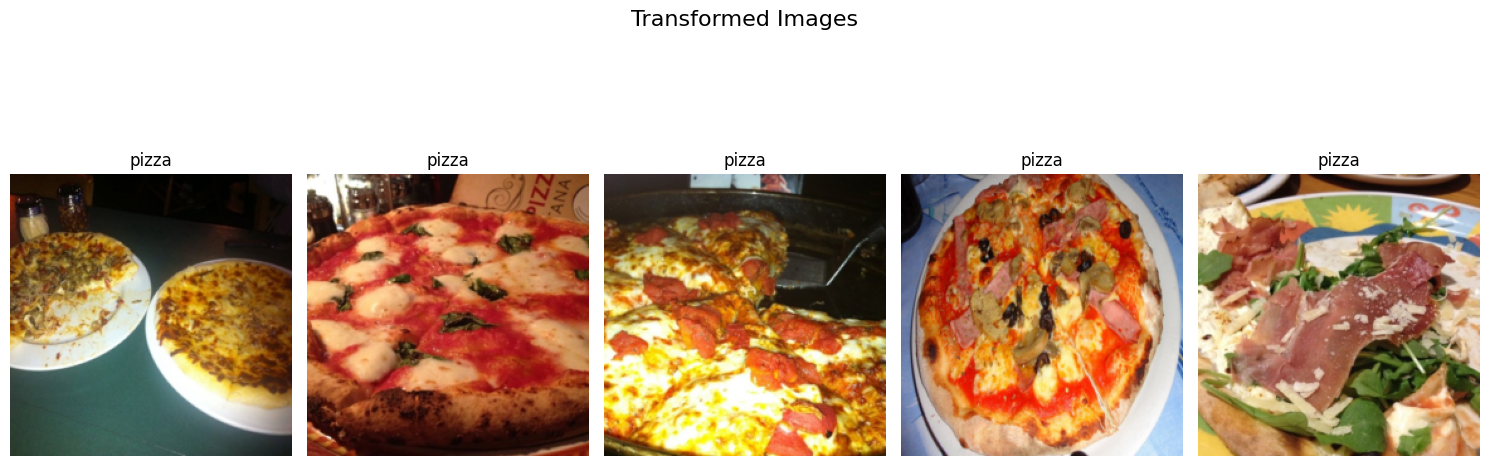

In [18]:
# Write a function to plot transformed images
import torch
import matplotlib.pyplot as plt

def plot_transformed_images(dataset, class_names, n=5):
    """Plots n transformed images from a torchvision dataset."""
    plt.figure(figsize=(15, 6))

    for i in range(n):
        image, label = dataset[i]  # get image and label
        image = image.permute(1, 2, 0)  # reshape from [C, H, W] to [H, W, C] for plotting

        # Undo normalization (ImageNet stats)
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        image = image * std + mean  # de-normalize
        image = torch.clamp(image, 0, 1)  # clip to valid range

        plt.subplot(1, n, i+1)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis("off")

    plt.suptitle("Transformed Images", fontsize=16)
    plt.tight_layout()
    plt.show()

# Use with transformed dataset
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform)
class_names = train_data.classes  # e.g. ['pizza', 'steak', 'sushi']
plot_transformed_images(train_data, class_names, n=5)

Load image data using ImageFolder

In [19]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

# Create training and testing datasets
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

In [20]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [21]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [22]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [37]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

# Define batch size
batch_size = 1

# Create DataLoader for training data
train_loader = DataLoader(dataset=train_data,
                          batch_size=batch_size,
                          shuffle=True)  # Shuffle data during training

# Create DataLoader for testing data
test_loader = DataLoader(dataset=test_data,
                         batch_size=batch_size,
                         shuffle=False)  # No shuffling for testing

# Return DataLoaders as a tuple
(train_loader, test_loader)

(<torch.utils.data.dataloader.DataLoader at 0x7d2a66bb8550>,
 <torch.utils.data.dataloader.DataLoader at 0x7d2a66bc4050>)

In [38]:
# How many batches of images are in our data loaders?
# Number of batches in each DataLoader
num_train_batches = len(train_loader)
num_test_batches = len(test_loader)

print(f"Number of batches in train DataLoader: {num_train_batches}")
print(f"Number of batches in test DataLoader: {num_test_batches}")


Number of batches in train DataLoader: 225
Number of batches in test DataLoader: 75


3. Recreate model_0 we built in section 7 of notebook 04.

In [39]:
import torch.nn as nn

class Model0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.model(x)


4. Create training and testing functions for model_0.

In [40]:
import torch

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = "cpu"):

    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader and data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy
        y_pred_class = y_pred.argmax(dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y)

    # Adjust metrics to get average loss and average accuracy per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [41]:
import torch

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = "cpu"):

    # Put model in eval mode
    model.eval()

    # Setup the test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for X, y in dataloader:
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(y)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc

In [42]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
Use torch.optim.Adam() with a learning rate of 0.001 as the optimizer.

In [45]:
def train(model,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn,
          epochs,
          device):

    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in range(epochs):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

        # Save metrics
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    return results

In [48]:
import torch.nn as nn

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# --- Train for 5 epochs ---
# Assuming Model0 class is defined earlier, instantiate it like this:
model_5 = Model0(input_shape=3*224*224, hidden_units=128, output_shape=len(class_names)).to(device)
optimizer_5 = torch.optim.Adam(model_5.parameters(), lr=0.001)
results_5 = train(model_5, train_loader, test_loader, optimizer_5, loss_fn, epochs=5, device=device)

# --- Train for 20 epochs ---
model_20 = Model0(input_shape=3*224*224, hidden_units=128, output_shape=len(class_names)).to(device)
optimizer_20 = torch.optim.Adam(model_20.parameters(), lr=0.001)
results_20 = train(model_20, train_loader, test_loader, optimizer_20, loss_fn, epochs=20, device=device)

# --- Train for 50 epochs ---
model_50 = Model0(input_shape=3*224*224, hidden_units=128, output_shape=len(class_names)).to(device)
optimizer_50 = torch.optim.Adam(model_50.parameters(), lr=0.001)
results_50 = train(model_50, train_loader, test_loader, optimizer_50, loss_fn, epochs=50, device=device)

Epoch 1/5 | Train Loss: 57.3284, Train Acc: 0.4711 | Test Loss: 53.0652, Test Acc: 0.3867
Epoch 2/5 | Train Loss: 17.1874, Train Acc: 0.6622 | Test Loss: 31.0660, Test Acc: 0.2800
Epoch 3/5 | Train Loss: 8.9915, Train Acc: 0.6889 | Test Loss: 18.2310, Test Acc: 0.4133
Epoch 4/5 | Train Loss: 10.2542, Train Acc: 0.6978 | Test Loss: 14.0458, Test Acc: 0.5467
Epoch 5/5 | Train Loss: 12.1530, Train Acc: 0.7200 | Test Loss: 25.7284, Test Acc: 0.4400
Epoch 1/20 | Train Loss: 53.2509, Train Acc: 0.4400 | Test Loss: 33.6350, Test Acc: 0.3067
Epoch 2/20 | Train Loss: 18.0123, Train Acc: 0.6578 | Test Loss: 13.7790, Test Acc: 0.3867
Epoch 3/20 | Train Loss: 10.4906, Train Acc: 0.6311 | Test Loss: 31.6039, Test Acc: 0.4133
Epoch 4/20 | Train Loss: 8.7748, Train Acc: 0.7378 | Test Loss: 23.9551, Test Acc: 0.4400
Epoch 5/20 | Train Loss: 4.0074, Train Acc: 0.8089 | Test Loss: 15.9202, Test Acc: 0.5200
Epoch 6/20 | Train Loss: 4.0810, Train Acc: 0.8044 | Test Loss: 21.9327, Test Acc: 0.4800
Epoch 7/

6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [49]:
import torch.nn as nn

class Model1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units * 2),  # Doubled hidden units
            nn.ReLU(),
            nn.Linear(hidden_units * 2, output_shape)
        )

    def forward(self, x):
        return self.model(x)

In [50]:
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [52]:
# Initialize model, optimizer, and loss function
model_doubled = Model1(input_shape=3*224*224, hidden_units=10, output_shape=3).to(device)  # Assuming input size is 3x64x64
optimizer = torch.optim.Adam(model_doubled.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Train the model for 20 epochs
results_doubled = train(model=model_doubled,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=20,
                        device=device)

Epoch 1/20 | Train Loss: 25.0921, Train Acc: 0.4400 | Test Loss: 12.0584, Test Acc: 0.4267
Epoch 2/20 | Train Loss: 6.4654, Train Acc: 0.5911 | Test Loss: 6.4688, Test Acc: 0.4267
Epoch 3/20 | Train Loss: 3.0603, Train Acc: 0.6489 | Test Loss: 9.9061, Test Acc: 0.3867
Epoch 4/20 | Train Loss: 1.5187, Train Acc: 0.6844 | Test Loss: 9.6326, Test Acc: 0.3867
Epoch 5/20 | Train Loss: 1.0622, Train Acc: 0.7689 | Test Loss: 6.6350, Test Acc: 0.4267
Epoch 6/20 | Train Loss: 0.4788, Train Acc: 0.8178 | Test Loss: 8.3170, Test Acc: 0.4533
Epoch 7/20 | Train Loss: 0.3353, Train Acc: 0.8400 | Test Loss: 8.8823, Test Acc: 0.3867
Epoch 8/20 | Train Loss: 3.4279, Train Acc: 0.6978 | Test Loss: 15.5658, Test Acc: 0.4400
Epoch 9/20 | Train Loss: 3.9495, Train Acc: 0.7511 | Test Loss: 12.8766, Test Acc: 0.4400
Epoch 10/20 | Train Loss: 5.7328, Train Acc: 0.7289 | Test Loss: 15.2779, Test Acc: 0.4667
Epoch 11/20 | Train Loss: 3.1130, Train Acc: 0.7422 | Test Loss: 9.8962, Test Acc: 0.3867
Epoch 12/20 | 

7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
Note: You can use the custom data creation notebook to scale up your Food101 dataset.
You can also find the already formatted double data (20% instead of 10% subset) dataset on GitHub, you will need to write download code like in exercise 2 to get it into this notebook.

In [53]:
import requests
import zipfile
from pathlib import Path

# Define path to data and dataset URL
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
zip_url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20.zip"  # 20% subset URL
zip_path = data_path / "pizza_steak_sushi_20.zip"

# Check if the directory exists, if not, download and extract the dataset
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    print("Downloading pizza_steak_sushi_20.zip...")
    response = requests.get(zip_url)
    with open(zip_path, "wb") as f:
        f.write(response.content)

    # Unzip the dataset
    print("Unzipping pizza_steak_sushi_20.zip...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(image_path)

    print("Done!")

data/pizza_steak_sushi directory exists.


In [55]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transformations for the new data
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load train and test datasets
train_data_20 = datasets.ImageFolder(root=image_path / "train", transform=transform)
test_data_20 = datasets.ImageFolder(root=image_path / "test", transform=transform)

# Create DataLoader instances
train_loader_20 = DataLoader(train_data_20, batch_size=1, shuffle=True)
test_loader_20 = DataLoader(test_data_20, batch_size=1, shuffle=False)

# Check the number of batches
print(f"Number of train batches: {len(train_loader_20)}")
print(f"Number of test batches: {len(test_loader_20)}")

Number of train batches: 225
Number of test batches: 75


In [58]:
# Initialize model, optimizer, and loss function
model_doubled_data = Model1(input_shape=3*64*64, hidden_units=10, output_shape=3).to(device)  # Using doubled hidden units from Exercise 6
optimizer = torch.optim.Adam(model_doubled_data.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Train the model with the doubled data for 20 epochs
results_doubled_data = train(model=model_doubled_data,
                              train_dataloader=train_loader_20,
                              test_dataloader=test_loader_20,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=20,
                              device=device)

Epoch 1/20 | Train Loss: 3.2035, Train Acc: 0.4756 | Test Loss: 3.2783, Test Acc: 0.4000
Epoch 2/20 | Train Loss: 1.6749, Train Acc: 0.6889 | Test Loss: 2.2608, Test Acc: 0.4667
Epoch 3/20 | Train Loss: 0.9612, Train Acc: 0.7289 | Test Loss: 1.7917, Test Acc: 0.4800
Epoch 4/20 | Train Loss: 0.8449, Train Acc: 0.7333 | Test Loss: 3.4035, Test Acc: 0.4400
Epoch 5/20 | Train Loss: 0.8438, Train Acc: 0.8178 | Test Loss: 3.2720, Test Acc: 0.4667
Epoch 6/20 | Train Loss: 0.4468, Train Acc: 0.8311 | Test Loss: 2.8253, Test Acc: 0.5467
Epoch 7/20 | Train Loss: 0.2844, Train Acc: 0.8889 | Test Loss: 2.8447, Test Acc: 0.4933
Epoch 8/20 | Train Loss: 0.3046, Train Acc: 0.8889 | Test Loss: 2.9567, Test Acc: 0.5067
Epoch 9/20 | Train Loss: 0.3928, Train Acc: 0.8756 | Test Loss: 2.4698, Test Acc: 0.4933
Epoch 10/20 | Train Loss: 0.3353, Train Acc: 0.9022 | Test Loss: 2.6953, Test Acc: 0.4933
Epoch 11/20 | Train Loss: 0.1156, Train Acc: 0.9511 | Test Loss: 2.8015, Test Acc: 0.5467
Epoch 12/20 | Train

In [59]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


Excellent, we now have double the training and testing images...

In [60]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [61]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets
train_data_20_percent = ImageFolder(train_data_20_percent_path, transform=simple_transform)
test_data_20_percent = ImageFolder(test_data_20_percent_path, transform=simple_transform)

# Create dataloaders
train_dataloader_20_percent = DataLoader(train_data_20_percent, batch_size=1, shuffle=True)
test_dataloader_20_percent = DataLoader(test_data_20_percent, batch_size=1, shuffle=False)

In [62]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
Does the model you trained in exercise 7 get it right?
If not, what do you think you could do to improve it?

In [63]:
from PIL import Image
import torchvision.transforms as transforms

def preprocess_image(image_path):
    # Define transformations (same as during training)
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize to the expected input size
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
    ])

    # Open the image and apply the transformations
    image = Image.open(image_path).convert("RGB")  # Ensure the image is RGB
    image = transform(image)

    # Add batch dimension (model expects batch dimension, even if it's a single image)
    image = image.unsqueeze(0)

    return image

In [70]:
import torch

def predict(image_path, model, device):
    # Preprocess the custom image
    image = preprocess_image(image_path).to(device)

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():  # No need to track gradients during inference
        output = model(image)

    # Get the predicted class (index of max logit)
    _, predicted_class = torch.max(output, 1)

    # Convert the prediction index to class label
    class_names = ["pizza", "steak", "sushi"]  # Replace with actual class names if different
    predicted_label = class_names[predicted_class.item()]

    return predicted_label

In [104]:
import requests
from io import BytesIO
from PIL import Image
import torchvision.transforms as transforms

def download_image(url):
    # Download the image from the URL
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

def preprocess_image(image): # Changed the input argument to 'image'
    # Define transformations (same as during training)
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize to the expected input size
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
    ])

    # Apply the transformations
    image = transform(image)  # Directly apply transformations to the image object

    # Add batch dimension (model expects batch dimension, even if it's a single image)
    image = image.unsqueeze(0)

    return image

import torch

def predict(image, model, device): # Changed input from image_path to image
    # Preprocess the custom image
    image = preprocess_image(image).to(device) # Use the image object directly

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():  # No need to track gradients during inference
        output = model(image)

    # Get the predicted class (index of max logit)
    _, predicted_class = torch.max(output, 1)

    # Convert the prediction index to class label
    class_names = ["pizza", "steak", "sushi"]  # Replace with actual class names if different
    predicted_label = class_names[predicted_class.item()]

    return predicted_label

# Specify the URL to your custom image
image_url = "https://images.pexels.com/photos/1251208/pexels-photo-1251208.jpeg"

# Load the trained model (make sure to load your actual trained weights)
model_trained = Model1(input_shape=3*64*64, hidden_units=10, output_shape=3).to(device)
# Load your trained weights here if you saved them:
# model_trained.load_state_dict(torch.load('path/to/your/saved/model.pth'))

# Download the image from the URL
custom_image = download_image(image_url)

# Get the prediction for the custom image
prediction = predict(custom_image, model_trained, device)  # Pass the downloaded and preprocessed image
print(f"Prediction: {prediction}")

Prediction: steak
